In [1]:
import os
path = os.getcwd()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1  清洗数据

In [3]:
# 获取特征提取后的train、test数据
train = pd.read_csv(path + '/features/train.csv', sep = '\t')
test = pd.read_csv(path + '/features/test.csv', sep = '\t')

In [4]:
# 缺失值处理
train.fillna(-999, inplace = True)
test.fillna(-999, inplace = True)

In [5]:
# 所有列名
features = list(train.columns)
features.pop(0)

'USRID'

# 2  探索特征数据

In [ ]:
# 导入统计分析模块
from scipy import stats

# 察看各变量间的P值与拟合情况
statistic = []
for i in range(len(features) - 1):
    for j in range(i + 1, len(features)):
        stat = []
        # 计算两变量间的相关系数、P值
        r, p = stats.pearsonr(train[features[i]], train[features[j]])
        stat.append(features[i])
        stat.append(features[j])
        stat.append(r)
        stat.append(p)
        statistic.append(stat)

In [ ]:
feature_stats = pd.DataFrame(statistic,
                             columns = ['FEATURE_X',
                                        'FEATURE_Y',
                                        'PERSON_R',
                                        'P']
                            )
del statistic

In [ ]:
feature_stats.to_csv(path + '/features/feature_stats.csv', index = None, sep = '\t')
del feature_stats

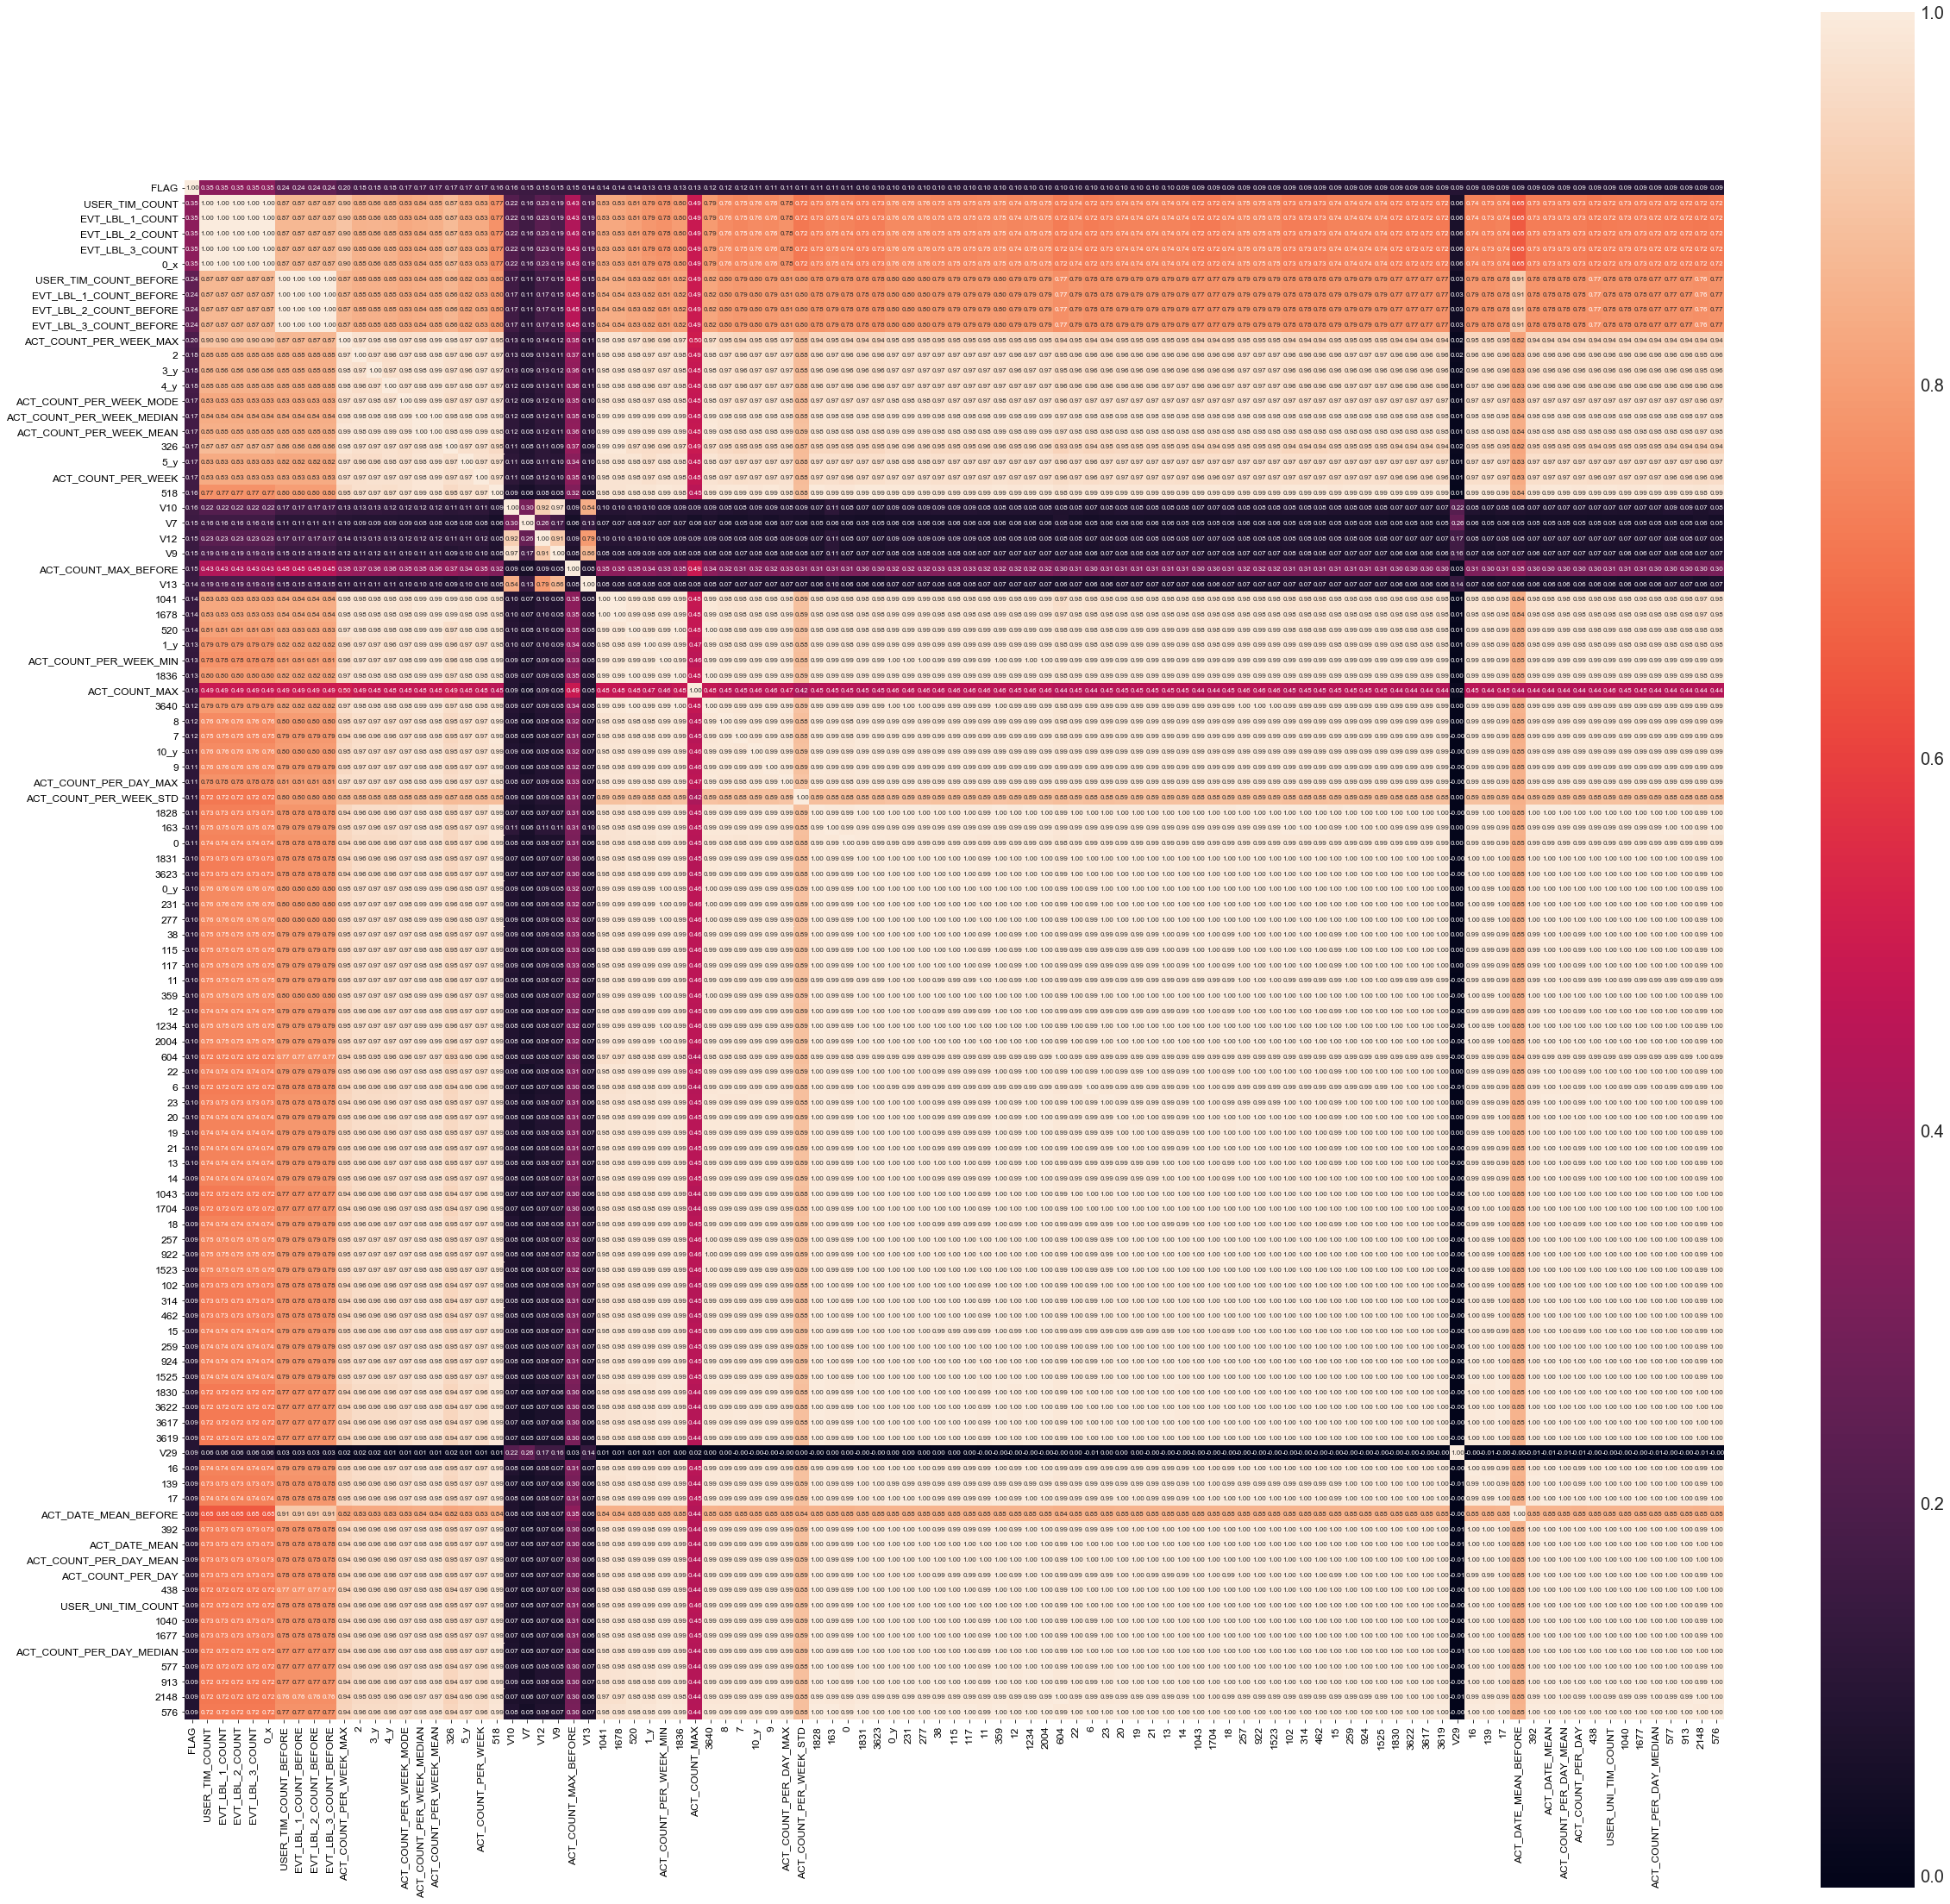

In [6]:
# 相关性最大的前100个特征间的相关系数显示
corr = train[features].corr()
feature_nums =  101
cols =  corr.nlargest(feature_nums, 'FLAG')['FLAG'].index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize = (40, 40))
sns.set(font_scale = 2)
hm = sns.heatmap(cm,
                 cbar = True,
                 annot = True,
                 square = True,
                 fmt = '.2f',
                 annot_kws = {'size' : 8},
                 yticklabels = cols.values,
                 xticklabels = cols.values
                )

# 设置刻度字体大小  
plt.xticks(fontsize = 12)  
plt.yticks(fontsize = 12)
plt.show()

In [ ]:
fig = plt.figure(figsize = (12, 8))
for i in range(1, 96):
    data_sub = pd.concat([train['FLAG'], train[features[i]]], axis = 1)
    sns.set_palette('muted')
    sns.jointplot(x = 'FLAG',
                  y = features[i],
                  data = data_sub,
                  kind = 'kde',
                  color = 'b',
                  space = 0.5,
                  ratio = 5)
    plt.title('FLAG' + ' - ' + features[i], fontsize = 18)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签  
    plt.rcParams['axes.unicode_minus'] = False   # 用来正常显示负号

D:\soft\anaconda3\envs\py35\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
D:\soft\anaconda3\envs\py35\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
D:\soft\anaconda3\envs\py35\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
D:\soft\anaconda3\envs\py35\lib\site-packages\matplotlib\contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
D:\soft\anaconda3\envs\py35\lib\site-packages\matplotlib\contour.py:1535: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


In [6]:
# 先初步划分数据集
train_x = train.drop(['USRID', 'FLAG', 'DAY'], axis = 1).values
train_y = train['FLAG'].values
del train

test_x = test.drop(['USRID', 'DAY'], axis = 1).values
UID = test[['USRID']]
del test

# 3  XGBoost建模预测

## 3.1 格网搜索超参数

In [7]:
import operator
import xgboost as xgb

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [9]:
# 所有列名
features.pop(0)
features.pop(50)

'DAY'

In [10]:
# 平衡数据处理
weights = ((train_y == 0).sum() / (1.0 * (train_y == 1).sum()))
print('平衡数据调整权重：', weights)

平衡数据调整权重： 6.406745945000655


In [11]:
X_dtrain, X_dtest, y_dtrain, y_dtest = train_test_split(train_x,
                                                        train_y,
                                                        test_size = 0.3,
                                                        random_state = 10)
# 转化为xgboost需要格式
xgb_train = xgb.DMatrix(X_dtrain, label = y_dtrain)
xgb_test = xgb.DMatrix(X_dtest)

In [12]:
# 搜索最佳参数
num_rounds = 500  # 迭代次数
watchlist = [(xgb_train, 'train')]
params = {}
params['booster'] = 'gbtree'
params['eval_metric'] = 'auc'  # 评价方式
params['silent'] = 0           # 设置成1则没有运行信息输出，最好是设置为0
params['eta'] = 0.03           # 如同学习率
params['scale_pos_weight'] = weights

xgb_params = []
for obj in ['binary:logistic', 'rank:pairwise']:
    params['objective'] = obj
    # 训练模型
    print('\n训练模型 ' + obj + ' :')
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/' + 'model_' + obj + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    if obj == 'binary:logistic':
        test_pred = (xgb_pred >= 0.5) * 1
        print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
        print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
        print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
        print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
        print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
        # 保存参数
        xgb_params.append([params['objective'],
                           metrics.roc_auc_score(y_dtest, xgb_pred),    # 衡量“二分类问题”机器学习算法性能(泛化能力)
                           metrics.accuracy_score(y_dtest, test_pred),  # 准确率，反映分类器对整个样本的判定能力：能将正的判定为正，负的判定为负
                           metrics.recall_score(y_dtest, test_pred),    # 召回率，反映被正确判定的正例占总正例的比重
                           metrics.precision_score(y_dtest, test_pred), # 精确度，反映被正确判定的样例中正例样本的比重
                           metrics.f1_score(y_dtest, test_pred)         # F1值，F1 = (2 * Recall * Accuracy)/ (Recall + Accuracy)
                          ])
    else:
        print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
        xgb_params.append([params['objective'],
                           metrics.roc_auc_score(y_dtest, xgb_pred)
                          ])


训练模型 binary:logistic :
[16:40:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-auc:0.858889
[16:40:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-auc:0.862752
[16:40:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-auc:0.864314
[16:40:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-auc:0.868209
[16:41:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-auc:0.870912
[16:41:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 r

[46]	train-auc:0.905982
[16:44:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[47]	train-auc:0.906415
[16:45:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[48]	train-auc:0.906579
[16:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[49]	train-auc:0.906991
[16:45:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[50]	train-auc:0.907695
[16:45:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[51]	train-auc:0.907928
[16:45:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[93]	train-auc:0.92536
[16:49:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[94]	train-auc:0.925806
[16:49:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[95]	train-auc:0.926264
[16:49:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[96]	train-auc:0.926571
[16:49:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[97]	train-auc:0.926819
[16:49:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[98]	train-auc:0.927262
[16:49:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 ro

[140]	train-auc:0.940525
[16:53:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[141]	train-auc:0.940696
[16:53:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[142]	train-auc:0.940821
[16:53:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[143]	train-auc:0.941227
[16:53:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[144]	train-auc:0.941734
[16:53:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[145]	train-auc:0.942184
[16:53:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[187]	train-auc:0.952494
[16:57:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[188]	train-auc:0.952628
[16:57:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[189]	train-auc:0.952725
[16:57:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[190]	train-auc:0.952961
[16:57:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[191]	train-auc:0.95302
[16:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[192]	train-auc:0.953175
[16:58:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[234]	train-auc:0.960456
[17:01:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[235]	train-auc:0.960556
[17:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[236]	train-auc:0.960811
[17:02:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[237]	train-auc:0.960862
[17:02:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[238]	train-auc:0.960924
[17:02:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[239]	train-auc:0.960985
[17:02:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[281]	train-auc:0.966635
[17:06:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[282]	train-auc:0.966816
[17:06:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[283]	train-auc:0.966879
[17:06:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[284]	train-auc:0.966927
[17:06:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[285]	train-auc:0.967032
[17:06:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[286]	train-auc:0.967113
[17:06:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[328]	train-auc:0.972342
[17:10:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[329]	train-auc:0.97242
[17:10:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[330]	train-auc:0.972677
[17:10:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[331]	train-auc:0.972731
[17:10:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[332]	train-auc:0.972785
[17:10:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[333]	train-auc:0.972878
[17:10:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[375]	train-auc:0.976508
[17:14:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[376]	train-auc:0.976504
[17:14:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[377]	train-auc:0.976526
[17:14:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[378]	train-auc:0.976677
[17:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[379]	train-auc:0.97675
[17:14:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[380]	train-auc:0.976776
[17:14:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[422]	train-auc:0.97969
[17:18:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[423]	train-auc:0.979816
[17:18:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[424]	train-auc:0.980062
[17:18:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[425]	train-auc:0.980309
[17:19:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[426]	train-auc:0.980378
[17:19:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[427]	train-auc:0.980405
[17:19:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[469]	train-auc:0.983096
[17:23:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[470]	train-auc:0.983103
[17:23:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[471]	train-auc:0.983123
[17:23:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[472]	train-auc:0.983162
[17:23:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[473]	train-auc:0.98318
[17:23:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[474]	train-auc:0.983199
[17:23:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[15]	train-auc:0.874968
[17:27:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16]	train-auc:0.875201
[17:27:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17]	train-auc:0.875569
[17:27:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18]	train-auc:0.877379
[17:27:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19]	train-auc:0.880136
[17:27:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[20]	train-auc:0.88093
[17:27:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[62]	train-auc:0.89865
[17:31:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[63]	train-auc:0.898865
[17:31:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[64]	train-auc:0.898995
[17:31:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[65]	train-auc:0.89919
[17:31:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[66]	train-auc:0.899592
[17:31:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[67]	train-auc:0.899945
[17:31:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[109]	train-auc:0.910938
[17:35:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[110]	train-auc:0.911044
[17:36:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[111]	train-auc:0.911175
[17:36:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[112]	train-auc:0.911559
[17:36:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[113]	train-auc:0.911972
[17:36:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[114]	train-auc:0.912322
[17:36:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[156]	train-auc:0.922709
[17:40:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[157]	train-auc:0.922894
[17:40:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[158]	train-auc:0.923137
[17:40:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[159]	train-auc:0.923317
[17:40:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[160]	train-auc:0.92358
[17:40:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[161]	train-auc:0.923728
[17:40:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[203]	train-auc:0.931264
[17:44:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[204]	train-auc:0.93138
[17:45:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[205]	train-auc:0.931439
[17:45:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[206]	train-auc:0.931586
[17:45:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[207]	train-auc:0.93178
[17:45:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[208]	train-auc:0.931933
[17:45:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[250]	train-auc:0.93777
[17:49:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[251]	train-auc:0.937834
[17:49:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[252]	train-auc:0.93795
[17:49:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[253]	train-auc:0.938025
[17:49:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[254]	train-auc:0.938148
[17:49:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[255]	train-auc:0.938387
[17:49:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[297]	train-auc:0.943709
[17:53:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[298]	train-auc:0.943815
[17:53:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[299]	train-auc:0.943877
[17:53:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[300]	train-auc:0.944087
[17:54:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[301]	train-auc:0.944238
[17:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[302]	train-auc:0.9443
[17:54:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[344]	train-auc:0.95028
[17:58:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[345]	train-auc:0.950363
[17:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[346]	train-auc:0.950607
[17:58:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[347]	train-auc:0.950683
[17:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[348]	train-auc:0.950863
[17:58:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[349]	train-auc:0.951025
[17:58:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[391]	train-auc:0.956012
[18:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[392]	train-auc:0.956062
[18:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[393]	train-auc:0.9562
[18:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[394]	train-auc:0.95625
[18:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[395]	train-auc:0.956417
[18:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[396]	train-auc:0.956583
[18:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[438]	train-auc:0.960244
[18:07:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[439]	train-auc:0.960295
[18:07:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[440]	train-auc:0.960413
[18:07:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[441]	train-auc:0.960508
[18:07:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[442]	train-auc:0.960554
[18:07:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[443]	train-auc:0.960685
[18:07:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[485]	train-auc:0.964401
[18:11:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[486]	train-auc:0.964428
[18:11:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[487]	train-auc:0.96459
[18:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[488]	train-auc:0.964608
[18:11:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[489]	train-auc:0.964802
[18:11:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[490]	train-auc:0.964903
[18:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

### 3.1.1 目标函数为'binary:logistic'的最优参数搜索

In [12]:
# 搜索最佳参数
num_rounds = 500  # 迭代次数
watchlist = [(xgb_train, 'train')]
params = {}
params['booster'] = 'gbtree'
params['eval_metric'] = 'auc'  # 评价方式
params['silent'] = 1           # 设置成1则没有运行信息输出，最好是设置为0
params['eta'] = 0.03           # 如同学习率
params['scale_pos_weight'] = weights

#### 3.1.1.1 max_depth

In [ ]:
params['objective'] = 'binary:logistic'

xgb_params = []
for max_depth in range(6, 9):
    params['max_depth'] = max_depth
    # 训练模型
    print('\n训练模型 max_depth : ' + str(max_depth))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/binary_logistic/' + 'model_max_depth_' + str(max_depth) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    test_pred = (xgb_pred >= 0.5) * 1
    print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
    print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
    print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
    print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
    # 保存参数
    xgb_params.append([params['max_depth'],
                       metrics.roc_auc_score(y_dtest, xgb_pred),
                       metrics.accuracy_score(y_dtest, test_pred),
                       metrics.recall_score(y_dtest, test_pred),
                       metrics.precision_score(y_dtest, test_pred),
                       metrics.f1_score(y_dtest, test_pred)
                      ])
xgb_params


训练模型 max_depth : 6
[18:31:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-auc:0.858889
[18:31:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-auc:0.862752
[18:32:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-auc:0.864314
[18:32:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-auc:0.868209
[18:32:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-auc:0.870912
[18:32:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots

[46]	train-auc:0.905982
[18:36:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[47]	train-auc:0.906415
[18:36:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[48]	train-auc:0.906579
[18:36:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[49]	train-auc:0.906991
[18:36:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[50]	train-auc:0.907695
[18:36:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[51]	train-auc:0.907928
[18:36:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[93]	train-auc:0.92536
[18:40:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[94]	train-auc:0.925806
[18:40:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[95]	train-auc:0.926264
[18:40:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[96]	train-auc:0.926571
[18:40:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[97]	train-auc:0.926819
[18:40:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[98]	train-auc:0.927262
[18:40:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 ro

[140]	train-auc:0.940525
[18:44:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[141]	train-auc:0.940696
[18:44:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[142]	train-auc:0.940821
[18:44:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[143]	train-auc:0.941227
[18:44:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[144]	train-auc:0.941734
[18:44:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[145]	train-auc:0.942184
[18:45:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[187]	train-auc:0.952494
[18:48:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[188]	train-auc:0.952628
[18:48:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[189]	train-auc:0.952725
[18:48:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[190]	train-auc:0.952961
[18:49:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[191]	train-auc:0.95302
[18:49:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[192]	train-auc:0.953175
[18:49:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[234]	train-auc:0.960456
[18:53:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[235]	train-auc:0.960556
[18:53:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[236]	train-auc:0.960811
[18:53:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[237]	train-auc:0.960862
[18:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[238]	train-auc:0.960924
[18:53:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[239]	train-auc:0.960985
[18:53:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[281]	train-auc:0.966635
[18:57:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[282]	train-auc:0.966816
[18:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[283]	train-auc:0.966879
[18:57:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[284]	train-auc:0.966927
[18:57:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[285]	train-auc:0.967032
[18:57:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[286]	train-auc:0.967113
[18:57:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[328]	train-auc:0.972342
[19:01:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[329]	train-auc:0.97242
[19:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[330]	train-auc:0.972677
[19:01:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[331]	train-auc:0.972731
[19:01:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[332]	train-auc:0.972785
[19:01:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[333]	train-auc:0.972878
[19:01:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[375]	train-auc:0.976508
[19:05:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[376]	train-auc:0.976504
[19:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[377]	train-auc:0.976526
[19:05:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[378]	train-auc:0.976677
[19:05:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[379]	train-auc:0.97675
[19:05:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[380]	train-auc:0.976776
[19:06:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[422]	train-auc:0.97969
[19:09:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[423]	train-auc:0.979816
[19:09:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[424]	train-auc:0.980062
[19:09:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[425]	train-auc:0.980309
[19:10:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[426]	train-auc:0.980378
[19:10:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[427]	train-auc:0.980405
[19:10:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[469]	train-auc:0.983096
[19:13:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[470]	train-auc:0.983103
[19:14:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[471]	train-auc:0.983123
[19:14:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[472]	train-auc:0.983162
[19:14:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[473]	train-auc:0.98318
[19:14:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[474]	train-auc:0.983199
[19:14:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[19:18:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[16]	train-auc:0.905584
[19:18:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[17]	train-auc:0.90722
[19:18:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[18]	train-auc:0.907553
[19:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[19]	train-auc:0.9086
[19:18:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[20]	train-auc:0.909896
[19:18:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes,

[62]	train-auc:0.937503
[19:23:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[63]	train-auc:0.938161
[19:23:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[64]	train-auc:0.938837
[19:23:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[65]	train-auc:0.939533
[19:23:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[66]	train-auc:0.939763
[19:23:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[67]	train-auc:0.940245
[19:23:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[109]	train-auc:0.957718
[19:28:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[110]	train-auc:0.957888
[19:28:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[111]	train-auc:0.958097
[19:28:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[112]	train-auc:0.958331
[19:28:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[113]	train-auc:0.958749
[19:28:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[114]	train-auc:0.9589
[19:28:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[156]	train-auc:0.966877
[19:33:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[157]	train-auc:0.967062
[19:33:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[158]	train-auc:0.967154
[19:33:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[159]	train-auc:0.967375
[19:33:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[160]	train-auc:0.96761
[19:33:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[161]	train-auc:0.967955
[19:33:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[203]	train-auc:0.97497
[19:37:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[204]	train-auc:0.975067
[19:37:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[205]	train-auc:0.975293
[19:38:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[206]	train-auc:0.975533
[19:38:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[207]	train-auc:0.975622
[19:38:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[208]	train-auc:0.975695
[19:38:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[250]	train-auc:0.980283
[19:42:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[251]	train-auc:0.980328
[19:42:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[252]	train-auc:0.980394
[19:42:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[253]	train-auc:0.980435
[19:42:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[254]	train-auc:0.980582
[19:43:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[255]	train-auc:0.98064
[19:43:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[297]	train-auc:0.984295
[19:47:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[298]	train-auc:0.984339
[19:47:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[299]	train-auc:0.98439
[19:47:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[300]	train-auc:0.984414
[19:47:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[301]	train-auc:0.984433
[19:47:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[302]	train-auc:0.984496
[19:47:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[344]	train-auc:0.987301
[19:52:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[345]	train-auc:0.987317
[19:52:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[346]	train-auc:0.987362
[19:52:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[347]	train-auc:0.98748
[19:52:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[348]	train-auc:0.98754
[19:52:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[349]	train-auc:0.987599
[19:52:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[391]	train-auc:0.989758
[19:57:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[392]	train-auc:0.98977
[19:57:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[393]	train-auc:0.989783
[19:57:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[394]	train-auc:0.989846
[19:57:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[395]	train-auc:0.989972
[19:57:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[396]	train-auc:0.989982
[19:57:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[438]	train-auc:0.991658
[20:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[439]	train-auc:0.991705
[20:02:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[440]	train-auc:0.991758
[20:02:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[441]	train-auc:0.991848
[20:02:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[442]	train-auc:0.991867
[20:02:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[443]	train-auc:0.99188
[20:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[485]	train-auc:0.993164
[20:06:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[486]	train-auc:0.993186
[20:06:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[487]	train-auc:0.993211
[20:06:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[488]	train-auc:0.993236
[20:07:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[489]	train-auc:0.993274
[20:07:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[490]	train-auc:0.993298
[20:07:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[31]	train-auc:0.938777
[20:12:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[32]	train-auc:0.938954
[20:12:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[33]	train-auc:0.939899
[20:12:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[34]	train-auc:0.9415
[20:12:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[35]	train-auc:0.941837
[20:12:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=8
[36]	train-auc:0.942939
[20:12:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[78]	train-auc:0.966083
[20:17:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=8
[79]	train-auc:0.966544
[20:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[80]	train-auc:0.966878
[20:17:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[81]	train-auc:0.96725
[20:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[82]	train-auc:0.967597
[20:17:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[83]	train-auc:0.967804
[20:18:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[125]	train-auc:0.979213
[20:22:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[126]	train-auc:0.979472
[20:23:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[127]	train-auc:0.979538
[20:23:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[128]	train-auc:0.979684
[20:23:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[129]	train-auc:0.979859
[20:23:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[130]	train-auc:0.979951
[20:23:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruni

#### 3.1.1.2 min_child_weight

In [ ]:
params['max_depth'] = 6

xgb_params = []
for min_child_weight in range(3, 10):
    params['min_child_weight'] = min_child_weight
    # 训练模型
    print('\n训练模型 min_child_weight : ' + str(min_child_weight))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/binary_logistic/' + 'model_min_child_weight_' + str(min_child_weight) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    test_pred = (xgb_pred >= 0.5) * 1
    print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
    print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
    print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
    print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
    # 保存参数
    xgb_params.append([params['min_child_weight'],
                       metrics.roc_auc_score(y_dtest, xgb_pred),
                       metrics.accuracy_score(y_dtest, test_pred),
                       metrics.recall_score(y_dtest, test_pred),
                       metrics.precision_score(y_dtest, test_pred),
                       metrics.f1_score(y_dtest, test_pred)
                      ])
xgb_params


训练模型 min_child_weight : 3
[0]	train-auc:0.858891
[1]	train-auc:0.862754
[2]	train-auc:0.864333
[3]	train-auc:0.86823
[4]	train-auc:0.871013
[5]	train-auc:0.872456
[6]	train-auc:0.873425
[7]	train-auc:0.874993
[8]	train-auc:0.875396
[9]	train-auc:0.876021
[10]	train-auc:0.87659
[11]	train-auc:0.87978
[12]	train-auc:0.882602
[13]	train-auc:0.883743
[14]	train-auc:0.884202
[15]	train-auc:0.884658
[16]	train-auc:0.886042
[17]	train-auc:0.886376
[18]	train-auc:0.886611
[19]	train-auc:0.88787
[20]	train-auc:0.889642
[21]	train-auc:0.889826
[22]	train-auc:0.890377
[23]	train-auc:0.89216
[24]	train-auc:0.893381
[25]	train-auc:0.894856
[26]	train-auc:0.895695
[27]	train-auc:0.896113
[28]	train-auc:0.896767
[29]	train-auc:0.897879
[30]	train-auc:0.898515
[31]	train-auc:0.899595
[32]	train-auc:0.900506
[33]	train-auc:0.90122
[34]	train-auc:0.901825
[35]	train-auc:0.902228
[36]	train-auc:0.902941
[37]	train-auc:0.903549
[38]	train-auc:0.904323
[39]	train-auc:0.905084
[40]	train-auc:0.905629
[41]	

[333]	train-auc:0.973222
[334]	train-auc:0.973245
[335]	train-auc:0.973283
[336]	train-auc:0.973303
[337]	train-auc:0.973365
[338]	train-auc:0.973492
[339]	train-auc:0.973527
[340]	train-auc:0.973601
[341]	train-auc:0.973632
[342]	train-auc:0.973725
[343]	train-auc:0.973807
[344]	train-auc:0.973898
[345]	train-auc:0.973964
[346]	train-auc:0.974005
[347]	train-auc:0.974038
[348]	train-auc:0.974131
[349]	train-auc:0.97416
[350]	train-auc:0.974222
[351]	train-auc:0.974257
[352]	train-auc:0.974274
[353]	train-auc:0.974316
[354]	train-auc:0.974345
[355]	train-auc:0.974378
[356]	train-auc:0.974404
[357]	train-auc:0.974588
[358]	train-auc:0.97463
[359]	train-auc:0.974656
[360]	train-auc:0.974689
[361]	train-auc:0.9747
[362]	train-auc:0.974757
[363]	train-auc:0.97477
[364]	train-auc:0.974794
[365]	train-auc:0.974838
[366]	train-auc:0.974888
[367]	train-auc:0.974901
[368]	train-auc:0.974938
[369]	train-auc:0.974958
[370]	train-auc:0.974972
[371]	train-auc:0.975106
[372]	train-auc:0.975115
[373]

[163]	train-auc:0.957526
[164]	train-auc:0.957631
[165]	train-auc:0.957809
[166]	train-auc:0.958157
[167]	train-auc:0.958205
[168]	train-auc:0.958373
[169]	train-auc:0.958504
[170]	train-auc:0.958568
[171]	train-auc:0.958675
[172]	train-auc:0.958748
[173]	train-auc:0.958785
[174]	train-auc:0.958825
[175]	train-auc:0.958916
[176]	train-auc:0.959044
[177]	train-auc:0.959305
[178]	train-auc:0.959465
[179]	train-auc:0.959534
[180]	train-auc:0.959614
[181]	train-auc:0.959842
[182]	train-auc:0.959872
[183]	train-auc:0.959915
[184]	train-auc:0.960202
[185]	train-auc:0.960417
[186]	train-auc:0.960494
[187]	train-auc:0.960533
[188]	train-auc:0.960599
[189]	train-auc:0.960692
[190]	train-auc:0.960897
[191]	train-auc:0.960985
[192]	train-auc:0.96122
[193]	train-auc:0.961445
[194]	train-auc:0.961515
[195]	train-auc:0.961582
[196]	train-auc:0.961629
[197]	train-auc:0.961667
[198]	train-auc:0.961874
[199]	train-auc:0.961968
[200]	train-auc:0.962048
[201]	train-auc:0.962133
[202]	train-auc:0.962345
[

[493]	train-auc:0.981896
[494]	train-auc:0.981964
[495]	train-auc:0.981993
[496]	train-auc:0.981999
[497]	train-auc:0.982027
[498]	train-auc:0.982258
[499]	train-auc:0.982376
AUC      : 0.9808
Accuary  : 0.9615
Recall   : 0.8988
Precesion: 0.8292
F1-score : 0.8626

训练模型 min_child_weight : 5
[0]	train-auc:0.858891
[1]	train-auc:0.862754
[2]	train-auc:0.864333
[3]	train-auc:0.86823
[4]	train-auc:0.871013
[5]	train-auc:0.872456
[6]	train-auc:0.873425
[7]	train-auc:0.874993
[8]	train-auc:0.875396
[9]	train-auc:0.876021
[10]	train-auc:0.87659
[11]	train-auc:0.87978
[12]	train-auc:0.882602
[13]	train-auc:0.883743
[14]	train-auc:0.884202
[15]	train-auc:0.884658
[16]	train-auc:0.886042
[17]	train-auc:0.886376
[18]	train-auc:0.886611
[19]	train-auc:0.88787
[20]	train-auc:0.889642
[21]	train-auc:0.889826
[22]	train-auc:0.890377
[23]	train-auc:0.89216
[24]	train-auc:0.893381
[25]	train-auc:0.894856
[26]	train-auc:0.895695
[27]	train-auc:0.896113
[28]	train-auc:0.896767
[29]	train-auc:0.897879
[30

#### 3.1.1.3 subsample

In [ ]:
params['min_child_weight'] = min_child_weight

xgb_params = []
for subsample in list(np.linspace(0.5, 1, 6)):
    params['subsample'] = subsample
    # 训练模型
    print('\n训练模型 subsample : ' + str(subsample))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/binary_logistic/' + 'model_subsample_' + str(subsample) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    test_pred = (xgb_pred >= 0.5) * 1
    print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
    print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
    print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
    print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
    # 保存参数
    xgb_params.append([params['subsample'],
                       metrics.roc_auc_score(y_dtest, xgb_pred),
                       metrics.accuracy_score(y_dtest, test_pred),
                       metrics.recall_score(y_dtest, test_pred),
                       metrics.precision_score(y_dtest, test_pred),
                       metrics.f1_score(y_dtest, test_pred)
                      ])
xgb_params

#### 3.1.1.4 colsample_bytree

In [ ]:
params['subsample'] = subsample

xgb_params = []
for colsample_bytree in list(np.linspace(0.5, 1, 6)):
    params['colsample_bytree'] = colsample_bytree
    # 训练模型
    print('\n训练模型 colsample_bytree : ' + str(colsample_bytree))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/binary_logistic/' + 'model_colsample_bytree_' + str(colsample_bytree) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    test_pred = (xgb_pred >= 0.5) * 1
    print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
    print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
    print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
    print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
    # 保存参数
    xgb_params.append([params['colsample_bytree'],
                       metrics.roc_auc_score(y_dtest, xgb_pred),
                       metrics.accuracy_score(y_dtest, test_pred),
                       metrics.recall_score(y_dtest, test_pred),
                       metrics.precision_score(y_dtest, test_pred),
                       metrics.f1_score(y_dtest, test_pred)
                      ])
xgb_params

#### 3.1.1.5 lambda

In [ ]:
params['colsample_bytree'] = colsample_bytree

xgb_params = []
for reg_lambda in list(np.linspace(0, 5, 11)):
    params['lambda'] = reg_lambda
    # 训练模型
    print('\n训练模型 lambda : ' + str(reg_lambda))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/binary_logistic/' + 'model_lambda_' + str(reg_lambda) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    test_pred = (xgb_pred >= 0.5) * 1
    print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
    print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
    print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
    print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
    # 保存参数
    xgb_params.append([params['lambda'],
                       metrics.roc_auc_score(y_dtest, xgb_pred),
                       metrics.accuracy_score(y_dtest, test_pred),
                       metrics.recall_score(y_dtest, test_pred),
                       metrics.precision_score(y_dtest, test_pred),
                       metrics.f1_score(y_dtest, test_pred)
                      ])
xgb_params

#### 3.1.1.6 alpha

In [ ]:
params['lambda'] = lambda

xgb_params = []
for reg_alpha in list(np.linspace(0, 5, 11)):
    params['alpha'] = reg_alpha
    # 训练模型
    print('\n训练模型 alpha : ' + str(reg_alpha))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/binary_logistic/' + 'model_alpha_' + str(reg_alpha) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    test_pred = (xgb_pred >= 0.5) * 1
    print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
    print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
    print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
    print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
    # 保存参数
    xgb_params.append([params['alpha'],
                       metrics.roc_auc_score(y_dtest, xgb_pred),
                       metrics.accuracy_score(y_dtest, test_pred),
                       metrics.recall_score(y_dtest, test_pred),
                       metrics.precision_score(y_dtest, test_pred),
                       metrics.f1_score(y_dtest, test_pred)
                      ])
xgb_params

#### 3.1.1.7 rate_drop

In [ ]:
params['alpha'] = alpha

xgb_params = []
for rate_drop in list(np.linspace(0, 1, 11)):
    params['rate_drop'] = rate_drop
    # 训练模型
    print('\n训练模型 rate_drop : ' + str(rate_drop))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/binary_logistic/' + 'model_rate_drop_' + str(rate_drop) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    test_pred = (xgb_pred >= 0.5) * 1
    print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
    print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
    print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
    print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
    # 保存参数
    xgb_params.append([params['rate_drop'],
                       metrics.roc_auc_score(y_dtest, xgb_pred),
                       metrics.accuracy_score(y_dtest, test_pred),
                       metrics.recall_score(y_dtest, test_pred),
                       metrics.precision_score(y_dtest, test_pred),
                       metrics.f1_score(y_dtest, test_pred)
                      ])
xgb_params

#### 3.1.1.8 skip_drop

In [ ]:
params['rate_drop'] = rate_drop

xgb_params = []
for skip_drop in list(np.linspace(0, 1, 11)):
    params['skip_drop'] = skip_drop
    # 训练模型
    print('\n训练模型 skip_drop : ' + str(skip_drop))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/binary_logistic/' + 'model_skip_drop_' + str(skip_drop) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    test_pred = (xgb_pred >= 0.5) * 1
    print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
    print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
    print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
    print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
    # 保存参数
    xgb_params.append([params['skip_drop'],
                       metrics.roc_auc_score(y_dtest, xgb_pred),
                       metrics.accuracy_score(y_dtest, test_pred),
                       metrics.recall_score(y_dtest, test_pred),
                       metrics.precision_score(y_dtest, test_pred),
                       metrics.f1_score(y_dtest, test_pred)
                      ])
xgb_params

#### 3.1.1.9 gamma

In [ ]:
params['skip_drop'] = skip_drop

xgb_params = []
for gamma in list(np.linspace(0, 0.5, 11)):
    params['gamma'] = gamma
    # 训练模型
    print('\n训练模型 gamma : ' + str(gamma))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/binary_logistic/' + 'model_gamma_' + str(gamma) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    test_pred = (xgb_pred >= 0.5) * 1
    print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
    print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
    print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
    print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
    # 保存参数
    xgb_params.append([params['gamma'],
                       metrics.roc_auc_score(y_dtest, xgb_pred),
                       metrics.accuracy_score(y_dtest, test_pred),
                       metrics.recall_score(y_dtest, test_pred),
                       metrics.precision_score(y_dtest, test_pred),
                       metrics.f1_score(y_dtest, test_pred)
                      ])
xgb_params

#### 3.1.1.10 seed

In [ ]:
params['gamma'] = gamma

xgb_params = []
for seed in range(0, 1001, 100):
    params['seed'] = seed
    # 训练模型
    print('\n训练模型 seed : ' + str(seed))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/binary_logistic/' + 'model_seed_' + str(seed) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    test_pred = (xgb_pred >= 0.5) * 1
    print('AUC      : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    print('Accuary  : %.4f' % metrics.accuracy_score(y_dtest, test_pred))
    print('Recall   : %.4f' % metrics.recall_score(y_dtest, test_pred))
    print('Precesion: %.4f' % metrics.precision_score(y_dtest, test_pred))
    print('F1-score : %.4f' % metrics.f1_score(y_dtest, test_pred))
    # 保存参数
    xgb_params.append([params['seed'],
                       metrics.roc_auc_score(y_dtest, xgb_pred),
                       metrics.accuracy_score(y_dtest, test_pred),
                       metrics.recall_score(y_dtest, test_pred),
                       metrics.precision_score(y_dtest, test_pred),
                       metrics.f1_score(y_dtest, test_pred)
                      ])
xgb_params

In [ ]:
# 转化为xgboost需要格式
xgb_train = xgb.DMatrix(train_x, label = train_y)
xgb_test = xgb.DMatrix(test_x)

# 模型参数
params = {'booster': 'gbtree',
          'objective': 'rank:pairwise',  # 二分类的问题 
          'eval_metric': 'auc',          # 评价方式
          'max_depth': 5,                # 构建树的深度，越大越容易过拟合
          'min_child_weight': 3          # 这个参数默认是 1，即每个叶子里面 h 的和至少是多少
                                         # 对正负样本不均衡时的 0-1 分类而言, 假设 h 在 0.01 附近
                                         # min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本
                                         # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值
                                         # 该参数值越小，越容易 overfitting
          'subsample': 0.7,              # 随机采样训练样本
          'colsample_bytree': 0.7,       # 生成树时进行的列采样
          'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2
          'alpha': ,
          'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
          'seed': ,
          'rate_drop': ,
          'skip_drop': ,
          'silent': 0,                   # 设置成1则没有运行信息输出，最好是设置为0
          'eta': 0.03,                   # 如同学习率
          'scale_pos_weight': weights,
         }
plst = list(params.items())

# 训练XGBoost模型
model = xgb.train(plst, xgb_train, num_rounds, watchlist)
model.save_model(path + '/models/private.model')

# 预测结果并输出
xgb_pred = model.predict(xgb_test)
a = pd.DataFrame(xgb_pred, columns = ['RST'])
res = pd.concat([UID, a['RST']], axis = 1)
res.to_csv(path + '/result/private_result.csv', index = None, sep = '\t')

In [ ]:
# 确定特征因子重要性
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘制重要性前 100 的特征重要性评分
colours = plt.cm.Set1(np.linspace(0, 1, 100))
fig = plt.figure(figsize = (16, 24))
ax = fig.add_subplot(111)
ax = xgb.plot_importance(model1,
                         max_number_features = 100,
                         height = 0.8,
                         color = colours,
                         grid = False,
                         show_values = True,
                         importance_type = 'cover',
                         ax = ax)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('重要性评分', size = 16)
ax.set_ylabel('特征', size = 16)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.set_title('模型学习后特征重要性排序', size = 20)

In [ ]:
# 模型重要性的决策树可视化
os.environ['PATH'] += os.pathsep + 'D:/Graphviz2.38/bin'
xgb.to_graphviz(model1)

In [ ]:
from sklearn.model_selection import learning_curve
# 学习曲线显示精度
trainSizes, trainScores, crossValScores = learning_curve(
    XGBClassifier(),
    train_x,
    train_y,
    cv = 5,
    scoring = 'accuracy'
)

In [ ]:
trainScoresMean = np.mean(trainScores, axis = 1)
trainScoresStd = np.std(trainScores, axis = 1)
crossValScoresMean = np.mean(crossValScores, axis = 1)
crossValScoresStd = np.std(crossValScores, axis = 1)

fig = plt.figure(figsize = (12, 8))
plt.fill_between(trainSizes,
                 trainScoresMean - trainScoresStd,
                 trainScoresMean + trainScoresStd,
                 alpha = 0.1,
                 color = 'b')
plt.fill_between(trainSizes,
                 crossValScoresMean - crossValScoresStd,
                 crossValScoresMean + crossValScoresStd,
                 alpha = 0.1,
                 color = 'r')
plt.plot(trainSizes,
         trainScores.mean(axis = 1),
         'o-',
         label = 'TRAIN',
         color = 'b')
plt.plot(trainSizes,
         crossValScores.mean(axis = 1),
         'o-',
         label = 'CROSS-VAL',
         color = 'r')

ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles,
           ['TRAIN', 'CROSS-VAL'],
           bbox_to_anchor = (0.8, 0.15),
           loc = 2,
           borderaxespad = 0,
           fontsize = 16)
plt.xlabel('TRAIN', size = 16)
plt.ylabel('AUC', size = 16)
plt.title('Learning Curves (all features and part samples)', size = 20)

In [ ]:
# 输出结果
res_pred = model1.predict(test_x)
a = pd.DataFrame(res_pred, columns = ['RST'])
res = pd.concat([UID, a['RST']], axis = 1)
res.to_csv(path + '/result/all_feat_split_result.csv', index = None, sep = '\t')
del res_pred

### 3.1.2 目标函数为'rank:pairwise'的最优参数搜索

In [ ]:
# 搜索最佳参数
num_rounds = 500  # 迭代次数
watchlist = [(xgb_train, 'train')]
params = {}
params['booster'] = 'gbtree'
params['eval_metric'] = 'auc'  # 评价方式
params['silent'] = 1           # 设置成1则没有运行信息输出，最好是设置为0
params['eta'] = 0.03           # 如同学习率
params['scale_pos_weight'] = weights

#### 3.1.2.1 max_depth

In [ ]:
params['objective'] = 'rank:pairwise'

xgb_params = []
for max_depth in range(3, 10):
    params['max_depth'] = max_depth
    # 训练模型
    print('\n训练模型 max_depth : ' + str(max_depth))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/rank_pairwise/' + 'model_max_depth_' + str(max_depth) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    print('AUC : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    # 保存参数
    xgb_params.append([params['max_depth'],
                       metrics.roc_auc_score(y_dtest, xgb_pred)
                      ])
xgb_params

#### 3.1.2.2 min_child_weight

In [ ]:
params['max_depth'] = max_depth

xgb_params = []
for min_child_weight in range(1, 10):
    params['min_child_weight'] = min_child_weight
    # 训练模型
    print('\n训练模型 min_child_weight : ' + str(min_child_weight))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/rank_pairwise/' + 'model_min_child_weight_' + str(min_child_weight) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    print('AUC : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    # 保存参数
    xgb_params.append([params['min_child_weight'],
                       metrics.roc_auc_score(y_dtest, xgb_pred)
                      ])
xgb_params

#### 3.1.2.3 subsample

In [ ]:
params['min_child_weight'] = min_child_weight

xgb_params = []
for subsample in list(np.linspace(0.5, 1, 6)):
    params['subsample'] = subsample
    # 训练模型
    print('\n训练模型 subsample : ' + str(subsample))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/rank_pairwise/' + 'model_subsample_' + str(subsample) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    print('AUC : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    # 保存参数
    xgb_params.append([params['subsample'],
                       metrics.roc_auc_score(y_dtest, xgb_pred)
                      ])
xgb_params

#### 3.1.2.4 colsample_bytree

In [ ]:
params['subsample'] = min_child_weight

xgb_params = []
for colsample_bytree in list(np.linspace(0.5, 1, 6)):
    params['colsample_bytree'] = colsample_bytree
    # 训练模型
    print('\n训练模型 colsample_bytree : ' + str(colsample_bytree))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/rank_pairwise/' + 'model_colsample_bytree_' + str(colsample_bytree) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    print('AUC : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    # 保存参数
    xgb_params.append([params['colsample_bytree'],
                       metrics.roc_auc_score(y_dtest, xgb_pred)
                      ])
xgb_params

#### 3.1.2.5 lambda

In [ ]:
params['colsample_bytree'] = colsample_bytree

xgb_params = []
for reg_lambda in list(np.linspace(0, 5, 11)):
    params['lambda'] = reg_lambda
    # 训练模型
    print('\n训练模型 lambda : ' + str(reg_lambda))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/rank_pairwise/' + 'model_lambda_' + str(reg_lambda) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    print('AUC : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    # 保存参数
    xgb_params.append([params['lambda'],
                       metrics.roc_auc_score(y_dtest, xgb_pred)
                      ])
xgb_params

#### 3.1.2.6 alpha

In [ ]:
params['lambda'] = lambda

xgb_params = []
for alpha in list(np.linspace(0, 5, 11)):
    params['alpha'] = alpha
    # 训练模型
    print('\n训练模型 alpha : ' + str(alpha))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/rank_pairwise/' + 'model_alpha_' + str(alpha) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    print('AUC : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    # 保存参数
    xgb_params.append([params['alpha'],
                       metrics.roc_auc_score(y_dtest, xgb_pred)
                      ])
xgb_params

#### 3.1.2.7 rate_drop

In [ ]:
params['alpha'] = alpha

xgb_params = []
for skip_drop in list(np.linspace(0, 1, 11)):
    params['rate_drop'] = rate_drop
    # 训练模型
    print('\n训练模型 rate_drop : ' + str(rate_drop))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/rank_pairwise/' + 'model_rate_drop_' + str(rate_drop) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    print('AUC : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    # 保存参数
    xgb_params.append([params['rate_drop'],
                       metrics.roc_auc_score(y_dtest, xgb_pred)
                      ])
xgb_params

#### 3.1.2.8 skip_drop

In [ ]:
params['rate_drop'] = rate_drop

xgb_params = []
for skip_drop in list(np.linspace(0, 1, 11)):
    params['skip_drop'] = rate_drop
    # 训练模型
    print('\n训练模型 skip_drop : ' + str(skip_drop))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/rank_pairwise/' + 'model_skip_drop_' + str(skip_drop) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    print('AUC : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    # 保存参数
    xgb_params.append([params['skip_drop'],
                       metrics.roc_auc_score(y_dtest, xgb_pred)
                      ])
xgb_params

#### 3.1.2.9 gamma

In [ ]:
params['skip_drop'] = rate_drop

xgb_params = []
for gamma in list(np.linspace(0, 0.5, 11)):
    params['gamma'] = rate_drop
    # 训练模型
    print('\n训练模型 gamma : ' + str(gamma))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/rank_pairwise/' + 'model_gamma_' + str(gamma) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    print('AUC : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    # 保存参数
    xgb_params.append([params['gamma'],
                       metrics.roc_auc_score(y_dtest, xgb_pred)
                      ])
xgb_params

#### 3.1.2.10 seed

In [ ]:
params['gamma'] = gamma

xgb_params = []
for seed in range(0, 1001, 100):
    params['seed'] = seed
    # 训练模型
    print('\n训练模型 seed : ' + str(seed))
    plst = list(params.items())
    model = xgb.train(plst, xgb_train, num_rounds, watchlist)
    model.dump_model(path + '/models/rank_pairwise/' + 'model_seed_' + str(seed) + '.txt')
    
    # 预测测试集结果
    xgb_pred = model.predict(xgb_test)
    print('AUC : %.4f' % metrics.roc_auc_score(y_dtest, xgb_pred))
    # 保存参数
    xgb_params.append([params['seed'],
                       metrics.roc_auc_score(y_dtest, xgb_pred)
                      ])
xgb_params

## 3.2 用已有模型训练xgboost模型

In [16]:
# 转化为xgboost需要格式
xgb_train = xgb.DMatrix(train_x, label = train_y)
xgb_test = xgb.DMatrix(test_x)

In [17]:
# 模型参数
params = {'booster': 'gbtree',
          'objective': 'rank:pairwise',  # 二分类的问题
          # 'gamma':0.1,                 # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2
          'max_depth': 5,                # 构建树的深度，越大越容易过拟合
          # 'lambda':2,                  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
          'subsample': 0.7,              # 随机采样训练样本
          'colsample_bytree': 0.7,       # 生成树时进行的列采样
          'min_child_weight': 3,         # 这个参数默认是 1，即每个叶子里面 h 的和至少是多少
                                         # 对正负样本不均衡时的 0-1 分类而言, 假设 h 在 0.01 附近
                                         # min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本
                                         # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值
                                         # 该参数值越小，越容易 overfitting
          'silent': 0,                   # 设置成1则没有运行信息输出，最好是设置为0
          'eta': 0.03,                   # 如同学习率
          'eval_metric': 'auc'           # 评价方式
         }

plst = list(params.items())
num_rounds = 500  # 迭代次数
watchlist = [(xgb_train, 'train')]

In [18]:
# 训练模型并预测
model1 = xgb.train(plst, xgb_train, num_rounds, watchlist)
xgb_pred = model1.predict(xgb_test)

[21:19:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-auc:0.842248
[21:19:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-auc:0.857778
[21:19:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-auc:0.858121
[21:19:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-auc:0.859925
[21:19:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-auc:0.859734
[21:19:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 prune

[21:23:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[47]	train-auc:0.874711
[21:23:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[48]	train-auc:0.875062
[21:23:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[49]	train-auc:0.875536
[21:23:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[50]	train-auc:0.87582
[21:23:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[51]	train-auc:0.876112
[21:23:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 p

[21:27:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[94]	train-auc:0.883708
[21:27:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[95]	train-auc:0.883987
[21:27:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[96]	train-auc:0.884263
[21:27:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[97]	train-auc:0.884474
[21:27:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[98]	train-auc:0.884716
[21:27:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 

[140]	train-auc:0.891979
[21:31:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[141]	train-auc:0.892133
[21:31:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[142]	train-auc:0.892332
[21:31:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[143]	train-auc:0.892406
[21:31:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[144]	train-auc:0.892571
[21:31:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[145]	train-auc:0.892748
[21:31:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[187]	train-auc:0.898832
[21:35:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[188]	train-auc:0.898957
[21:35:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[189]	train-auc:0.899157
[21:35:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[190]	train-auc:0.89929
[21:35:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[191]	train-auc:0.899432
[21:35:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[192]	train-auc:0.899534
[21:35:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[234]	train-auc:0.905408
[21:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[235]	train-auc:0.905466
[21:38:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[236]	train-auc:0.905654
[21:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[237]	train-auc:0.905799
[21:39:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[238]	train-auc:0.906043
[21:39:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[239]	train-auc:0.906132
[21:39:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[281]	train-auc:0.913329
[21:42:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[282]	train-auc:0.913629
[21:42:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[283]	train-auc:0.913694
[21:42:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[284]	train-auc:0.91404
[21:43:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[285]	train-auc:0.914155
[21:43:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[286]	train-auc:0.914318
[21:43:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[328]	train-auc:0.920831
[21:46:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[329]	train-auc:0.921064
[21:46:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[330]	train-auc:0.921308
[21:47:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[331]	train-auc:0.921397
[21:47:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[332]	train-auc:0.921448
[21:47:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[333]	train-auc:0.921659
[21:47:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[375]	train-auc:0.927139
[21:50:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[376]	train-auc:0.927211
[21:50:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[377]	train-auc:0.927294
[21:50:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[378]	train-auc:0.927404
[21:50:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[379]	train-auc:0.927525
[21:51:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[380]	train-auc:0.927595
[21:51:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[422]	train-auc:0.93227
[21:54:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[423]	train-auc:0.932374
[21:54:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[424]	train-auc:0.932456
[21:54:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[425]	train-auc:0.932513
[21:54:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[426]	train-auc:0.932688
[21:54:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[427]	train-auc:0.932737
[21:54:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[469]	train-auc:0.937451
[21:58:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[470]	train-auc:0.937598
[21:58:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[471]	train-auc:0.937696
[21:58:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[472]	train-auc:0.937773
[21:58:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[473]	train-auc:0.937855
[21:58:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[474]	train-auc:0.937891
[21:58:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

In [20]:
a = pd.DataFrame(xgb_pred, columns = ['RST'])
res = pd.concat([UID, a['RST']], axis = 1)
res.to_csv(path + '/result/exist_result.csv', index = None, sep = '\t')